In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score
%matplotlib inline

#Boston House Prices

###Analyzing dataset

In [2]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
col=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','PRICE']
dataset=pd.read_fwf(link,names=col)
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


We notice that we have continuous data in almost all our columns (including target) and we do not have null values. 

Next we will split the data for our stacking algorithm.

In [4]:
#Data
scaler = MinMaxScaler()
X=dataset.ix[:,0:-1]
X = scaler.fit_transform(X)

#Target
y=dataset.ix[:,-1]

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

###Stacking Diagram

For our stacking algorithm, we will collect predictions from Ridge Regression, Random Forest and Gradient Boosting on Stack 0. The parameters from Stack 0 will be optimized using Linear Regression in Stack 1. All 4 Regressors were picked based on the fact that we are dealing with continuous data.

<img src="Flowchart.png">

###Stack 0

We will use Ridge Regression, Random Forest Classifier and Gradient Boosting for our base stack. 

The reasons are:
- Ridge Regression will deal with multicolinearity
- Random Forest will have a high accuracy 
- Gradient Boost will be resistant to overfit

In [5]:
def stack0(data,target):
    '''Train classifiers of Stack0'''
    
    classifiers = [Ridge(fit_intercept=True, normalize=True),
                  RandomForestRegressor(),
                  GradientBoostingRegressor()]

    columns=['Ridge',
             'Random_Forest',
             'Gradient_Boost']

    stack0 = {}
    
    clfs = {}

    #Split dataset into train and target for classification
    data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.33, random_state=42)
    stack0['PRICE'] = target_test
    
    #Train classifiers and store the classifiers with predictions
    for clf,col in zip(classifiers,columns):  
        clf.fit(data_train,target_train)
        pred = clf.predict(data_test)
        stack0[col]=pred
        clfs[col]=clf

    #Create Dataframe for visualization
    stack0_df = pd.DataFrame(stack0)

    return stack0_df, clfs

Sample train data from Stack 0

In [6]:
train0 = stack0(X_train, y_train)
train0[0].head()

,Gradient_Boost,PRICE,Random_Forest,Ridge
173,22.770963,23.6,23.86,26.150729
274,31.914874,32.4,31.90,32.001075
491,15.831544,13.6,15.19,17.499830
72,23.931056,22.8,24.23,24.874509
452,17.096761,16.1,17.82,18.276161


Analyzing accuracy of individual classifiers:

In [7]:
df = train0[0]

cols = ['Gradient_Boost', 'Random_Forest', 'Ridge']
for col in cols:
    score = float(np.sum([np.isclose(i,j,atol=5) for i,j in zip(df['PRICE'],df[col])]))/len(df['PRICE'])
    print col,':','%.2f'%(score*100),'%'

Gradient_Boost : 91.02 %
Random_Forest : 88.02 %
Ridge : 80.24 %


###Stack 1

Next we tune the base classifiers with Linear Regression in Stack 1. Linear Regression is used as we are dealing with continuous data from Stack 0. This will allow us to calculate the weights for each classifier from Stack 0.

In [8]:
def stack1(data,target):
    '''Perform Linear Regression on Stack0 classifiers'''
    
    #Get dataframe and classifier list from Stack0
    stack0_df, clfs = stack0(data,target)
    
    ##Get coefficient for each classifier
    columns=['Ridge','Random_Forest','Gradient_Boost']
    clf = LinearRegression()
    clf.fit(stack0_df[columns].values, stack0_df['PRICE'].values)
    coefficients = clf.coef_ 
    intercept = clf.intercept_
    
    return coefficients, intercept ,clfs

###Final Computation

Next we get the score and analyze our prediction

In [9]:
def stack_score(train_data, train_target, test_data, test_target):
    '''Combine Stack0 and Stack1 to calculate score'''
    
    columns=['Ridge','Random_Forest','Gradient_Boost']
    
    #Collect data from Stack1 (which did the computation from Stack0)
    coefficients, intercept, clfs = stack1(train_data, train_target)
    
    #Array of zeros for adding weighted predictions
    prediction = np.zeros(len(test_data))
    
    #Calculate intercept
    intercept_array = np.empty(len(test_data))
    intercept_array.fill(intercept)
    
    #Add weighted predictions
    for i in range(len(columns)):
        prediction += coefficients[i]*clfs[columns[i]].predict(test_data)
    prediction += intercept_array
    
    #Collect score
    tol = np.std(y_test)    
    score = float(np.sum([np.isclose(i,j,atol=tol) for i,j in zip(prediction,test_target)]))/len(test_target)
    
    return score, prediction

Score:	98.20 %


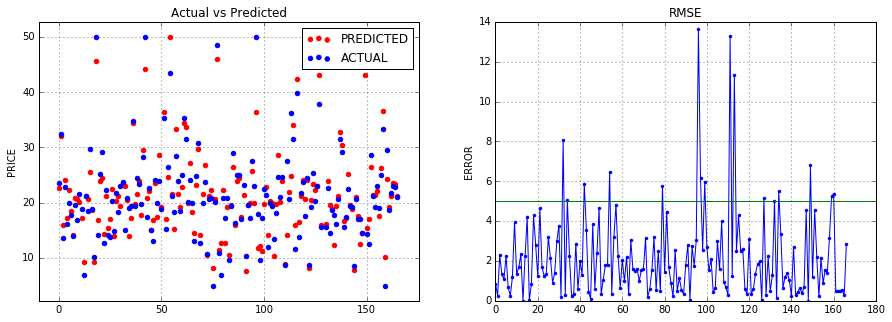

In [13]:
score, prediction = stack_score(X_train, y_train, X_test, y_test)
print 'Score:\t','%.2f'%(score*100),'%'

plt.figure(figsize=(15,5))

#Actual vs Predicted
plt.subplot(1,2,1)
plt.scatter(range(len(prediction)),prediction,color='red')
plt.scatter(range(len(y_test)),y_test, color='blue')
plt.title('Actual vs Predicted')
plt.ylabel('PRICE')
plt.legend(['PREDICTED','ACTUAL'], loc=0)
plt.axis('tight')
plt.grid()

#MSE
plt.subplot(1,2,2)
plt.plot(abs(prediction-y_test.values), '.-')
plt.axhline(y=5, color='green')
plt.title('RMSE')
plt.ylabel('ERROR')
plt.grid();

- Score achieved from data is very high (95%+).
- Actual and Predicted data points are close to eachother.
- Most of our RMSE values are below the $5,000 threshold.
- Stacked classifier performed better than the individual base classifiers.